# About
This kernel applies the techniques from fastai's deep learning for coders course to the planet dataset

# Setup
Make sure that **GPU** is **on** and internet is **connected** in your Kaggle kernel settings

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from fastai.conv_learner import *

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# make sure CUDA is available and enabled
print(torch.cuda.is_available(), torch.backends.cudnn.enabled)

True True


In [4]:
comp_name = "planet"

# use with custom environment
input_path = "/home/ubuntu/data/planet/"
wd = "/home/ubuntu/kaggle/planet/"

# use with kaggle kernels
#input_path = "../input/"
#wd = "/kaggle/working/"

## Helper function to deal with Kaggle's file system limitations

In [4]:
def create_symlnk(src_dir, src_name, dst_name, dst_dir=wd, target_is_dir=False):
    """
    If symbolic link does not already exist, create it by pointing dst_dir/dst_name to src_dir/dst_name
    """
    if not os.path.exists(dst_dir + dst_name):
        os.symlink(src=src_dir + src_name, dst = dst_dir + dst_name, target_is_directory=target_is_dir)

In [13]:
def clean_up(wd=wd):
    """
    Delete all temporary directories and symlinks in working directory (wd)
    """
    for root, dirs, files in os.walk(wd):
        try:
            for d in dirs:
                if os.path.islink(d):
                    os.unlink(d)
                else:
                    shutil.rmtree(d)
            for f in files:
                if os.path.islink(f):
                    os.unlink(f)
                else:
                    print(f)
        except FileNotFoundError as e:
            print(e)

In [14]:
create_symlnk(input_path, "train_v2.csv", "train.csv")
create_symlnk(input_path, "sample_submission_v2.csv", "sample.csv")
create_symlnk(input_path, "train-jpg", "train", target_is_dir=True)
create_symlnk(input_path, "test-jpg", "test", target_is_dir=True)

FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/data/planet/train_v2.csv' -> 'home/ubuntu/kaggle/planet/train.csv'

In [18]:
!ls -alh

total 40K
drwxrwxr-x 3 ubuntu ubuntu 4.0K Aug 22 14:09 .
drwxrwxr-x 5 ubuntu ubuntu 4.0K Aug 22 13:32 ..
drwxrwxr-x 2 ubuntu ubuntu 4.0K Aug 22 13:35 .ipynb_checkpoints
-rw-r--r-- 1 ubuntu ubuntu  27K Aug 22 14:09 planet-with-fastai.ipynb
lrwxrwxrwx 1 ubuntu ubuntu   33 Aug 22 14:05 test-jpg -> /home/ubuntu/data/planet/test-jpg
lrwxrwxrwx 1 ubuntu ubuntu   34 Aug 22 14:06 train-jpg -> /home/ubuntu/data/planet/train-jpg
lrwxrwxrwx 1 ubuntu ubuntu   37 Aug 22 14:04 train.csv -> /home/ubuntu/data/planet/train_v2.csv


# Inspect data

In [5]:
train_df = pd.read_csv(f"{wd}train.csv")

In [6]:
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [7]:
train_df.shape

(40479, 2)

In [8]:
train_df.pivot_table(index="tags", aggfunc=len).sort_values("image_name", ascending=False)

,image_name
tags,
clear primary,13636
partly_cloudy primary,3630
cloudy,2089
clear primary water,1850
agriculture clear primary road,1680
agriculture clear primary,1626
haze primary,1471
agriculture clear cultivation primary,1170
agriculture clear habitation primary road,1125


In [6]:
val_idxs = get_cv_idxs(train_df.shape[0])

In [7]:
def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    """
    Use F2 score function from https://github.com/fastai/fastai/blob/master/courses/dl1/planet.py
    """
    import warnings
    from sklearn.metrics import fbeta_score
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)])

In [8]:
arch = resnet34
metrics = [f2]
sz = 224
bs = 64

In [11]:
def get_data(sz=sz):
    """
    Load images via fastai's ImageClassifer.from_csv() object
    """
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(path=wd, folder="train", csv_fname=f"{wd}train.csv", tfms=tfms, val_idxs=val_idxs, suffix=".jpg", test_name="test")

In [12]:
data = get_data()

In [13]:
# get a single image
x, y = next(iter(data.val_ds))

In [14]:
x

array([[[-1.28147, -1.20441, -1.11049, ..., -1.30127, -1.2531 , -1.12841],
        [-1.22795, -1.18675, -1.11771, ..., -1.35211, -1.38903, -1.32588],
        [-1.17256, -1.15624, -1.12092, ..., -1.30876, -1.4083 , -1.42061],
        ...,
        [-0.51246, -0.45199, -0.39901, ..., -0.88251, -0.77415, -0.63661],
        [-0.54296, -0.46644, -0.39901, ..., -0.7613 , -0.64089, -0.51299],
        [-0.5641 , -0.46965, -0.39901, ..., -0.66926, -0.54724, -0.42683]],

       [[-0.94371, -0.89612, -0.81898, ..., -1.04657, -1.02851, -0.91964],
        [-0.92402, -0.88135, -0.82062, ..., -1.09964, -1.098  , -1.00171],
        [-0.89858, -0.86493, -0.8239 , ..., -1.08322, -1.12097, -1.07474],
        ...,
        [-0.28501, -0.24125, -0.18462, ..., -0.55829, -0.46884, -0.39142],
        [-0.31127, -0.26751, -0.20842, ..., -0.47376, -0.37693, -0.29377],
        [-0.33097, -0.28337, -0.2128 , ..., -0.44258, -0.3441 , -0.26094]],

       [[-0.82187, -0.79464, -0.7399 , ..., -0.93353, -0.89431, -0.786

In [15]:
y

array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.], dtype=float32)

In [16]:
list(zip(data.classes, y))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

In [17]:
#plt.imshow(data.val_ds.denorm(to_np(x)[0])*1.4)

In [18]:
data2 = get_data(64)

In [19]:
data2 = data2.resize(int(64*1.3), "tmp")

# Model

## Baseline

In [20]:
learn = ConvLearner.pretrained(arch, data2, metrics=metrics)

In [22]:
lrf = learn.lr_find()

epoch      trn_loss   val_loss   f2                          
    0      0.232699   0.323957   0.771243  



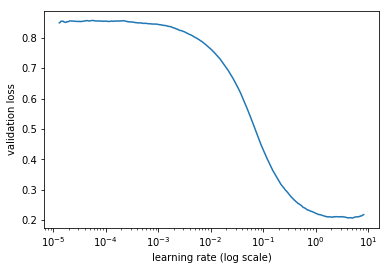

In [23]:
learn.sched.plot()

In [25]:
lr = 0.2

In [25]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.147266   0.133782   0.881559  
    1      0.140418   0.127907   0.888978                    
    2      0.137227   0.125767   0.891433                    
    3      0.141837   0.124971   0.892385                    
    4      0.134653   0.123367   0.892754                    
    5      0.132763   0.121477   0.895045                    
    6      0.131274   0.121397   0.89522                     



[array([0.1214]), 0.8952199442164059]

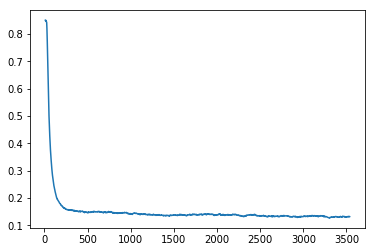

In [26]:
learn.sched.plot_loss()

In [30]:
learn.save(f"{comp_name}_{arch.__name__}_{sz}_base")

In [ ]:
learn.load(f"{comp_name}_{arch.__name__}_{sz}_base")

## Differential learning rates

In [26]:
lrs = [lr/9, lr/3, lr]

In [32]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.120823   0.108943   0.907554  
    1      0.117287   0.106633   0.91252                     
    2      0.109353   0.100711   0.915386                    
    3      0.110576   0.102643   0.913382                    
    4      0.107191   0.099672   0.917178                    
    5      0.101947   0.097254   0.919946                     
    6      0.098051   0.096558   0.918867                     

CPU times: user 11min 22s, sys: 4min 9s, total: 15min 32s
Wall time: 11min 10s


[array([0.09656]), 0.9188665158848887]

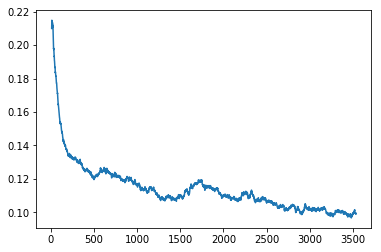

In [33]:
learn.sched.plot_loss()

In [34]:
learn.save(f"{comp_name}_{arch.__name__}_{sz}_dr")

In [35]:
learn.load(f"{comp_name}_{arch.__name__}_{sz}_dr")

## Increase image size to 128 pixels

In [21]:
sz = 128

In [37]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.097295   0.094818   0.919051  
    1      0.09833    0.092778   0.921079                     
    2      0.099773   0.092857   0.920725                     
    3      0.09797    0.09281    0.921811                     
    4      0.094822   0.092292   0.920843                     
    5      0.095216   0.091622   0.922164                     
    6      0.096292   0.091818   0.921971                     



[array([0.09182]), 0.9219705869734545]

In [27]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.103189   0.096573   0.918673  
    1      0.102821   0.098465   0.916815                    
    2      0.098651   0.095492   0.920468                     
    3      0.099063   0.097414   0.920367                     
    4      0.100736   0.095971   0.920036                     
    5      0.093614   0.095156   0.920124                     
    6      0.091859   0.094111   0.921319                     



[array([0.09411]), 0.9213185050470052]

In [28]:
learn.save(f"{comp_name}_{arch.__name__}_{sz}")

In [29]:
learn.load(f"{comp_name}_{arch.__name__}_{sz}")

## Further increase image size to 256 pixels

In [31]:
sz = 256
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.10982    0.103733   0.90994   
    1      0.103789   0.098262   0.916241                    
    2      0.102225   0.097567   0.916727                    
    3      0.105362   0.096919   0.917682                    
    4      0.104482   0.096019   0.917304                     
    5      0.103142   0.094587   0.919591                     
    6      0.100758   0.094681   0.919554                     



[array([0.09468]), 0.919553774661241]

In [32]:
learn.save(f"{comp_name}_{arch.__name__}_{sz}")

In [ ]:
learn.unfreeze()
learn.fit(lrs, cycle_len=1, cycle_mult=2)

In [ ]:
learn.load(f"{comp_name}_{arch.__name__}_{sz}")

## Prediction on validation set

In [ ]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0) # average over 4 synthetic images generated by TTA and 1 original image

In [ ]:
f2(preds, y)

## Prediction on test set

In [ ]:
multi_preds_test, y_test = learn.TTA(is_test=est=True)
preds_test = np.mean(multi_preds_test, 0)

In [ ]:
f2(preds_test, y_test)

# Submission

In [ ]:
sample_df = pd.read_csv(f"{wd}sample.csv)

In [ ]:
sample_df.head()

In [ ]:
df = pd.DataFrameFrame(preds_test)

In [ ]:
df.head()